In [161]:
import numpy as np
import pandas as pd
import warnings
from sklearn import feature_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

In [162]:
warnings.filterwarnings('ignore')

df = pd.read_csv('wisconsin.data')

df.columns = ['ID', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
             'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 
              'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

df = df.apply(pd.to_numeric, errors='coerce').fillna(np.nan).dropna()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           682 non-null    int64  
 1   Clump Thickness              682 non-null    int64  
 2   Uniformity of Cell Size      682 non-null    int64  
 3   Uniformity of Cell Shape     682 non-null    int64  
 4   Marginal Adhesion            682 non-null    int64  
 5   Single Epithelial Cell Size  682 non-null    int64  
 6   Bare Nuclei                  682 non-null    float64
 7   Bland Chromatin              682 non-null    int64  
 8   Normal Nucleoli              682 non-null    int64  
 9   Mitoses                      682 non-null    int64  
 10  Class                        682 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 63.9 KB
None


In [129]:
# Apply Select K Best class to extract all features ranking
X_independent = df.iloc[:, 1:10]
y_target = df.iloc[:, -1]
bf = feature_selection.SelectKBest(score_func=feature_selection.chi2, k=9)
fit = bf.fit(X_independent, y_target)
df_columns = pd.DataFrame(X_independent.columns)
df_scores = pd.DataFrame(fit.scores_)

# Concatenate two dataframes for better visualization
featureScore = pd.concat([df_columns, df_scores], axis=1)
featureScore.columns = ['Specs', 'Score']
print(featureScore.nlargest(9, 'Score'),'\n')

                         Specs        Score
5                  Bare Nuclei  1725.454497
1      Uniformity of Cell Size  1367.255595
2     Uniformity of Cell Shape  1277.002682
7              Normal Nucleoli  1141.580025
3            Marginal Adhesion   984.341910
6              Bland Chromatin   683.035713
0              Clump Thickness   625.115963
4  Single Epithelial Cell Size   496.790690
8                      Mitoses   228.643574 



<function matplotlib.pyplot.show(close=None, block=None)>

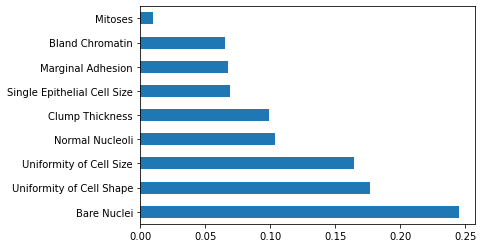

In [130]:
# Apply extratreesclassifier class to extract important features in order
X_independent = df.iloc[:, 1:10]
y_target = df.iloc[:, -1]
model = ExtraTreesClassifier()
model.fit(X_independent, y_target)

# Plot graph of feature importances for better visualization
plt.clf()
feat_importances = pd.Series(model.feature_importances_, index=X_independent.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show

In [131]:
# Select feature
# As I run two feature selection library (SelectKBeat, Extratreesclassifier)
# Columns "Mistoses" have poor score in both
# So I am going to use all features without "ID" and "Mistoses"
data = df.iloc[:, 1:9].astype(np.int32)

# Change class value 2,4 to 0,1 for convenience
target = df.iloc[:, [-1]]
encoder = LabelEncoder()
target.loc[:, 'Class'] = encoder.fit_transform(target.loc[:, 'Class'])


In [143]:
# define scaler and model list to use
# Scaler list use 3 kinds of scaler that we learn at DataScience class
scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler()]

# Model list use 4 kinds of models, each model define parameter
models = {
    DecisionTreeClassifier():{
        'criterion' : ['entropy'],
        'max_depth' : [None, 6, 9, 12],
        'min_samples_split' : [0.01, 0.05, 0.1, 1],
        'splitter' : ['best', 'random'],
        'max_features' : ['sqrt', 'log2']
    },
    DecisionTreeClassifier():{
        'criterion' : ['gini'],
        'max_depth' : [None, 6, 9, 12],
        'min_samples_split' : [0.01, 0.05, 0.1, 1],
        'splitter' : ['best', 'random'],
        'max_features' : ['sqrt', 'log2']
    },
    LogisticRegression():{
        'penalty' : ['l1', 'l2', 'elasticent', None],
        'solver' : ['liblinear', 'newton-cg', 'lbfgs'],
        'C' : [0.01, 0.1, 1]
    },
    SVC():{
        'degree' : [1,2,3,4,5],
        'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
        'C' : [0.01, 0.1, 1],
        'gamma' : [0.0001, 0.001, 0.01, 0.1, 1]
    }
}

In [157]:
# Make model function with scaling
'''
Parameters
scalers : list of scaler to use
models : list of model to use
x_train, x_test, y_train, y_test : train, test dataset to use
k : value about kfold k
'''

def Model_function(scalers, models, x_train, x_test, y_train, y_test, k):
    df_columns = ["Scaler", 'Model', 'k', 'Score', 'Parameter']
    result_list = []
    
    for scaler in scalers:
        if(scaler != None):
            x_test = scaler.fit_transform(x_test)
            x_train = scaler.fit_transform(x_train)
        
        for model in models:
            cv = KFold(k, shuffle=True, random_state=42)
            grid_search = GridSearchCV(
                estimator = model, param_grid = dict(models[model].items()), 
                cv = cv, scoring = 'accuracy', error_score=0
            )
            grid_result = grid_search.fit(x_train, y_train.values.ravel())
#             estimatior = grid_result.best_estimator_
#             y_pred = estimatior.predict(x_test)
            
            # summarize result
            print("%s %s Best: %f using %s"%(scaler, model, grid_result.best_score_, grid_result.best_params_))
            score = grid_result.best_score_
            result_list.append([scaler, model, k, score, grid_result.best_params_])
            
    result = pd.DataFrame(result_list, columns=df_columns)
    return result
            

In [159]:
# Run
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42, shuffle=True)

df_columns = ['Scaler', 'Model', 'k', "Score", 'Parameter']
result_final = pd.DataFrame(columns=df_columns)

for i in [3, 5, 7]:
    print("\n\nResult with KFold k = ", i)
    result_return = Model_function(scalers, models, x_train, x_test, y_train, y_test, i)
    result_final = pd.concat([result_final, result_return], axis = 0)

result_final = result_final.astype({"Score" : "float64"})


# print top 10 score
print('\n\n')
print(result_final.nlargest(10, 'Score'))



Result with KFold k =  3
None DecisionTreeClassifier() Best: 0.962458 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'splitter': 'random'}
None DecisionTreeClassifier() Best: 0.964116 using {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'splitter': 'random'}
None LogisticRegression() Best: 0.967384 using {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
None SVC() Best: 0.972286 using {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
StandardScaler() DecisionTreeClassifier() Best: 0.967400 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 0.05, 'splitter': 'random'}
StandardScaler() DecisionTreeClassifier() Best: 0.955994 using {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.1, 'splitter': 'random'}
StandardScaler() LogisticRegression() Best: 0.970652 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
